# Successor Representation Demo.
## Kim Stachenfeld
### 28 Nov 2023
#### stachenfeld@deepmind.com

This colab has demos of how to compute and visualize the successor representation for random + optimal policies over different environments, as well as its eigenvectors.

Simulations correspond to those in:

Stachenfeld, K., Botvinick, M. & Gershman, S. The hippocampus as a predictive map. *Nature Neuroscience* **20**, 1643--1653 (2017). https://doi.org/10.1038/nn.4650




In [145]:
#@title Imports
from typing import Callable, Optional, Union
import functools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.linalg
import seaborn as sns

# Environments.
Classes for different environments of interest.

Includes:
* `Track(n)` a 1D track of length `n`
* `BiasedTrack(n, p_right)` a 1D track with a biased propability of going to the right of `p_right`
* `Grid2D(x, y, lattice_type)` a 2D grid with the specified lattice type
* `SchapiroEtAl2016(n_clusters, n_in_cluster)` transition graph with `n_clusters` clusters connected in a ring, each cluster containing `n_in_cluster` nodes

Enter `?<Name of environment>` (e.g. `?Track`) to view documentation for each class.

In [146]:
#@title Utility functions to check if variables are valid
"""Functions to check if variables supplied are valid."""

def is_scalar_0inc_1exc(scalar, scalar_name):
  """Checks if scalar is scalar and 0<=scalar<1, else raises ValueError."""
  err_msg = ('{} {} invalid: must be scalar such that 0 <= '
             '{} < 1.').format(scalar_name, scalar, scalar_name)
  if not np.isscalar(scalar):
    raise ValueError(err_msg)
  if (scalar < 0.) or (scalar >= 1.):
    raise ValueError(err_msg)


def is_scalar_gteq0(scalar, scalar_name):
  """Checks if scalar is scalar and 0<=scalar, else raises ValueError."""
  err_msg = ('{} {} invalid: must be scalar >= 0.').format(scalar_name, scalar)
  if not np.isscalar(scalar):
    raise ValueError(err_msg)
  if scalar < 0.:
    raise ValueError(err_msg)


def is_nonneg(matrix, matrix_name):
  """Checks all entries in matrix are nonnegaive, else raises ValueError."""
  if np.any(matrix) < 0:
    raise ValueError('{} cannot have negative entries.'.format(matrix_name))


def is_square_matrix(matrix, matrix_name):
  """Checks if matrix is square, else raises ValueError."""
  err_msg = ('{} with shape {} invalid: must be matrix with same'
             ' number of rows and columns.').format(matrix_name, matrix.shape)
  if len(matrix.shape) != 2:
    raise ValueError(err_msg)
  if matrix.shape[0] != matrix.shape[1]:
    raise ValueError(err_msg)


def check_discount(discount_):
  """Checks if discount is scalar and 0<=discount<1, else raises ValueError."""
  is_scalar_0inc_1exc(discount_, 'discount')


def check_beta_softmax(beta_):
  """Checks if beta is scalar and 0<=beta, else raises ValueError."""
  is_scalar_gteq0(beta_, 'beta_softmax')


def check_reward(reward_, n_state):
  """Checks if reward is valid reward vector, else raises ValueError."""
  err_msg = 'reward must be array with shape (n_state,).'
  if reward_.shape != (n_state,):
    raise ValueError(err_msg)

def almost_equal(x, y, atol=1e-6):
  return np.abs(x-y) < atol


def check_transmat(transmat_, atol=1e-6):
  """Checks if transmat is valid transition matrix, else raises ValueError."""
  is_square_matrix(transmat_, 'transmat')
  is_nonneg(transmat_, 'transmat')
  if not np.all(almost_equal(transmat_.sum(1), 1, atol)):
    raise ValueError(('All rows of transmat must sum to 1 or 0. You may want to'
                      ' call l1_normalize_rows() on the input matrix.'))


def check_weighted_adjmat(adjmat_):
  """Checks if adjmat is valid adjacency matrix, else raises ValueError."""
  is_square_matrix(adjmat_, 'adjmat')
  is_nonneg(adjmat_, 'adjmat')


def check_unweighted_adjmat(adjmat_, atol=1e-6):
  """Checks if adjmat is valid adjacency matrix, else raises ValueError."""
  check_weighted_adjmat(adjmat_)
  if not np.all(almost_equal(adjmat_, 1, atol) + almost_equal(adjmat_, 0, atol)):
    raise ValueError('All entries in adjmat must be 1 or 0.')


def check_successor_repmat(srmat_):
  """Checks if srmat is valid successor rep matrix, else raises ValueError."""
  is_square_matrix(srmat_, 'srmat')
  is_nonneg(srmat_, 'srmat')


In [147]:
#@title Plotting functions.

def plot_graph(
    adj: np.ndarray, pos: np.ndarray, colors: Optional[np.ndarray] = None,
    ax: Optional[plt.Axes] = None, **kwargs):
  """Plot graph.

  Args:
    adj: n x n adjacency matrix
    pos: n x 2 x, y positions for each node
    colors: length n array or n x 3 array with colors of each node
    ax: plt.gca axis object

  """
  if ax is None:
    ax = plt.gca()

  g = nx.from_numpy_array(adj)
  nx.draw_networkx_edges(g, pos=pos, ax=ax)

  if colors is None:
    default_color = sns.color_palette('tab10')[0]
    colors = np.stack([default_color] * adj.shape[0], axis=0)

  nx.draw_networkx_nodes(
      g, pos=pos, node_color=colors, ax=ax, **kwargs)
  ax.axis('equal')
  ax.axis('off')


def plot_columns_as_fields(adj, pos, mat, **kwargs):
  if mat.ndim == 1:
    mat = mat[:, None]

  n_plots = mat.shape[1]
  n_plot_x, n_plot_y = [int(np.ceil(np.sqrt(n_plots)))] * 2

  fig, axes = plt.subplots(
      n_plot_y, n_plot_x, figsize=(n_plot_x * 3, n_plot_y * 3), squeeze=False)
  for i, ax in enumerate(axes.reshape(-1)):
    if i < mat.shape[1]:
      plot_graph(adj, pos, mat[:, i], ax=ax, **kwargs)
    else:
      ax.axis('off')

  return fig, axes


def plot_columns_as_fields_square_grid(x: int, y: int, mat: np.ndarray,
                                       share_caxis: bool = True):
  if mat.ndim == 1:
    mat = mat[:, None]

  n_plots = mat.shape[1]
  n_plot_x, n_plot_y = [int(np.ceil(np.sqrt(n_plots)))] * 2

  vmin = None
  vmax = None
  if share_caxis:
    vmin = np.nanmin(mat)
    vmax = np.nanmax(mat)

  fig, axes = plt.subplots(
      n_plot_y, n_plot_x, figsize=(n_plot_x * 3, n_plot_y * 3), squeeze=False)
  for i, ax in enumerate(axes.reshape(-1)):
    if i < mat.shape[1]:
      ax.imshow(mat[:, i].reshape(x, y), vmin=vmin, vmax=vmax)
    else:
      ax.axis('off')

  return fig, axes


def plot_columns_as_fields_1D(mat):
  if mat.ndim == 1:
    mat = mat[:, None]

  n_plots = mat.shape[1]
  n_plot_x, n_plot_y = [int(np.ceil(np.sqrt(n_plots)))] * 2

  fig, axes = plt.subplots(
      n_plot_y, n_plot_x, figsize=(n_plot_x * 3, n_plot_y * 3), squeeze=False,
      sharex=True, sharey=True)

  for i, ax in enumerate(axes.reshape(-1)):
    if i < mat.shape[1]:
      ax.plot(mat[:, i], '.-')
    else:
      ax.axis('off')

  return fig, axes


In [148]:
#@title Code to define environments.
class Environment:
  """Class for generating environments."""

  def __init__(
      self, adj: np.ndarray, pos: np.ndarray,
      reward: Optional[np.ndarray] = None, labels: Optional[np.ndarray] = None,
      name: str = 'GraphEnv', atol: float = 1e-6):
    """Initialize.

    Args:
      adj: n x n array containing the adjacency matrix.
      pos: n x 2 array containing the positions of each node, for plotting
      reward: Optional, (n,) reward vector containing instantaneous reward for
        each node.
      labels: Optional, (n,) vector containing labels of each node
      atol: tolerance for checking matrices are valid.
      name: name of environment
    """

    assert adj.shape[1] == adj.shape[1]
    assert adj.ndim == 2
    assert pos.shape[0] == adj.shape[0]

    self._n = adj.shape[0]
    self._adj = adj
    self._pos = pos
    self._degree = adj.sum(1)
    self._trans = self._adj / self._degree[:, None]
    self._labels = np.zeros(self._n) if labels is None else labels
    self._reward = np.zeros(self._n) if reward is None else reward
    assert self._labels.shape[0] == self._n
    assert self._reward.shape[0] == self._n
    self._name = name

    # Check transition matrix rows sum to 1.
    assert np.all(np.abs(self._trans.sum(1) - 1) < atol)

  def plot_fields(self, mat, *args, **kwargs):
    """Plot activation maps for columns of mat."""
    return plot_columns_as_fields(
        env.adj, env.pos, mat, node_size=512/np.sqrt(env.n),)

  @property
  def n(self) -> int:
    """Number of nodes."""
    return self._n

  @property
  def adj(self) -> np.ndarray:
    """Adjacancy matrix."""
    return self._adj.copy()

  @property
  def pos(self) -> np.ndarray:
    """Node xy positions array."""
    return self._pos.copy()

  @property
  def trans(self) -> np.ndarray:
    """Transition probability matrix."""
    return self._trans

  @property
  def labels(self) -> np.ndarray:
    """Node labels."""
    return self._labels.copy()

  @property
  def reward(self) -> np.ndarray:
    """Instantaneous reward at each node."""
    return self._reward.copy()

  @property
  def name(self) -> str:
    return self._name


class Track(Environment):
  """1D linear track environment."""

  def __init__(self, n: int = 16, name: str = 'Track'):
    """Initialize.

    Args:
      n: number of nodes (default=16)
    """
    col = np.zeros(n)
    col[1] = 1
    adj = scipy.linalg.toeplitz(col)
    pos = np.stack([np.arange(n), np.zeros(n)], axis=1)
    super(Track, self).__init__(adj=adj, pos=pos, name=name)

  def plot_fields(self, mat, *args, **kwargs):
    fig, axes = plot_columns_as_fields_1D(mat)
    for ax in axes[:, 0]:
      ax.set_ylabel('Activation')
    for ax in axes[-1, :]:
      ax.set_xlabel('State')
    plt.tight_layout()
    return fig, axes


class BiasedTrack(Track):
  """1D linear track environment with a directional bias."""

  def __init__(self, n: int = 16, p_right: float = .8, name: str = 'Biased Track'):
    """Initialize.

    Args:
      n: number of nodes (default=16)
    """
    super(BiasedTrack, self).__init__(n=n, name=name)
    p_left = 1 - p_right
    self._trans = l1_normalize_rows(
        p_right * np.triu(self._adj) + p_left * np.tril(self._adj))


class Grid2D(Environment):
  """2D grid with the square or hexagonal lattice type."""

  def __init__(self, x: int = 16, y: int = 16, lattice_type: str = 'square'):
    """Initialize.

    Args:
      x: number of nodes in the x-direction (default=16)
      y: number of nodes in the y-direction (default=16)
      lattice_type: 'square' | 'hexagon' type of lattice (default='square')
    """

    if lattice_type == 'hexagon':
      g = nx.hexagonal_lattice_graph(x, y, with_positions=True)
      get_node_pos_ = lambda n: g.nodes[n]['pos']
      name = 'Hexagonal Grid'
    elif lattice_type == 'square':
      g = nx.grid_2d_graph(x, y)
      get_node_pos_ = lambda n: np.array(n)
      name = 'Square Grid'
    else:
      raise ValueError((
          f'lattice_type {lattice_type} not recognized: '
          'must be square or hexagon'))

    pos = []
    for n in g.nodes:
      pos.append(get_node_pos_(n))

    pos = np.array(pos)
    adj = nx.to_numpy_array(g)
    super(Grid2D, self).__init__(adj=adj, pos=pos, name=name)

    self._x = x
    self._y = y
    self._lattice_type = lattice_type

  def plot_fields(self, mat, share_caxis=True, *args, **kwargs):
    if self._lattice_type == 'hexagon':
      return super(Grid2D, self).plot_fields(mat, *args, **kwargs)
    else:
      fig, axes = plot_columns_as_fields_square_grid(
          env.x, env.y, mat, share_caxis=share_caxis)
      plt.tight_layout()
    return fig, axes

  @property
  def x(self) -> int:
    return self._x

  @property
  def y(self) -> int:
    return self._y


class SchapiroEtAl2016(Environment):
  """Transition graph with clusters connected in a ring."""

  def __init__(self, n_clusters: int = 3, n_in_cluster: int = 5):
    """Initialize.

    Args:
      n_clusters: number of clusters. Each cluster is connected in a
        near-clique, with the only edge missing being the one between the two
        nodes that connect to nodes outside the cluster (default=3).
      n_in_cluster: number of nodes per cluster (default=5)
    """
    adj = scipy.linalg.block_diag(
        *[np.ones((n_in_cluster, n_in_cluster))] * n_clusters)
    adj -= np.eye(adj.shape[0])

    # Add edges between clusters adjacent in ring.
    for i in range(n_in_cluster-1, adj.shape[0], n_in_cluster):
      adj[i, (i-n_in_cluster+1)%adj.shape[0]] = 0
      adj[(i-n_in_cluster+1)%adj.shape[0], i] = 0
      adj[i, (i+1)%adj.shape[0]] = 1
      adj[(i+1)%adj.shape[0], i] = 1

    labels = np.repeat(np.arange(0, n_clusters).reshape(-1, 1),
                       n_in_cluster, axis=0).reshape(-1)

    # Compute position.
    labels = np.repeat(np.arange(0, n_clusters).reshape(-1, 1),
                       n_in_cluster, axis=0).reshape(-1)

    # Clusters are arranged in a circle.
    # Assign each cluster an angle:
    cluster_angle = labels * 1.0 / n_clusters * 2 * np.pi
    cluster_pos = 2 * np.stack([np.cos(cluster_angle), np.sin(cluster_angle)],
                                axis=1)

    # Assign each point in cluster an angle.
    # Rotate clusters so they open toward the center.
    offset_in_cluster = np.pi - cluster_angle - np.pi / n_in_cluster
    angles_in_one_cluster = np.linspace(0, 2*np.pi, n_in_cluster+1)[:n_in_cluster]
    angles_in_clusters = np.concatenate(
        [angles_in_one_cluster] * n_clusters, axis=0) - offset_in_cluster
    pos = np.stack([np.cos(angles_in_clusters), np.sin(angles_in_clusters)], axis=1) + cluster_pos

    super(SchapiroEtAl2016, self).__init__(adj=adj, pos=pos, labels=labels,
                                           name='Ring of Clusters')


In [149]:
ENVIRONMENTS = {
    'Track': Track,
    'BiasedTrack': BiasedTrack,
    'Grid2D': Grid2D,
    'Grid2DHexagonal': functools.partial(Grid2D, lattice_type='hexagon'),
    'SchapiroEtAl2016': SchapiroEtAl2016,
}

# RL, Successor Representation, and Eigenvectors

Functions to compute quantities and matrices of interest for different environments.

Includes
* `compute_successor_representation` computes the successor representation given discount factor $\gamma\in[0, 1]$ and one-step transition probability matrix $T$:
<p style="text-align: center;">$M =\Sigma_{t=0}^\infty \gamma^t T^t = (I - \gamma T)^{-1}$</p>

* `compute_eigs` computer eigenvectors and eigenvalues of a specified matrix.
* `compute_optimal_policy` compute optimal policy using policy iteration


In [132]:
#@title Functions for computing RL + graph matrices of interest.

def l1_normalize_rows(mat):
  """Normalize non-zero rows of mat so that they sum to 1.

  Args:
    mat: matrix to normalize

  Returns:
    l1normmat: matrix with rows that sum to 1 or 0.
  """
  denom = np.sum(mat, axis=1)
  denom[denom == 0] = 1.
  l1normmat = np.divide(mat.T, denom).T
  return l1normmat


def softmax(vec, beta):
  """Apply softmax to vector vec.

  Args:
    vec: vector to compute softmax over
    beta: softmax inverse temperature parameter. Range [0 inclusive, infinity).
      For beta = 0, vec_softmax[i] will be uniform for all entries (1/len(vec)).
      As beta approaches infinity, vec_softmax[i] will approach 1 for
        argmax(vec) and zero everywhere else.

  Returns:
    vec_sftmx: vector of same shape as vec, where
      vec_softmax[i] = exp(beta vec[i]) / sum_i(exp(beta vec[i]))
  """
  check_beta_softmax(beta)
  if beta == np.inf:  # handle separately to avoid numerical instabilities
    vec_sftmx = np.zeros(vec.shape)
    vec_sftmx[vec == np.max(vec)] = 1.
  else:
    vec_sftmx = np.exp(vec * beta)
  vec_sftmx = vec_sftmx / np.sum(vec_sftmx)  # normalize so sums to 1
  return vec_sftmx


def compute_successor_representation(trans: np.ndarray, gamma: float) -> np.ndarray:
  """Compute successor representation.

  Args:
    trans: n x n transition matrix
    gamma: discount factor, s.t. 0 <= gamma < 1

  Returns:
    successor representation, (I - gamma * T)^-1
  """
  assert 0. <= gamma < 1.
  check_transmat(trans)
  n = trans.shape[0]
  sr = np.linalg.pinv(np.eye(n) - gamma * trans)
  check_successor_repmat(sr)
  return sr


def signed_amp(x: Union[float, complex, int]) -> float:
  """For complex number a+bi, return sign(a) * (a^2 + b^2)."""
  return np.sign(np.real(x)) * np.sqrt(np.real(x) ** 2 + np.imag(x) ** 2)


def compute_eigs(x: np.ndarray, sort_descending: bool = True, sortby: Callable[[float], float] = signed_amp, sparse: bool = True, n_eigs: Optional[int] = None):
  """Computes eigenvectors and returns them in eigenvalue order.

  Args:
    x: square matrix to eigendecompose
    sort_descending: if True, sort by eigenvalue descending order.
    sortby: function transforms a list of (possibly complex, possibly mixed
      sign) into real-valued scalars that can be sorted without ambiguity
      (default=signed_amp, where signed_amb(a + ib) = sign(a) * a^2 + b^2)
    sparse: if sparse, use scipy.sparse for faster computation
    n_eigs: int number of eigenvectors to compute (default=None, compute all
      x.shape[0] eigs)

  Returns:
    evals: matrix with eigenvector columns
    evecs: array of eigenvectors
  """
  assert x.shape[0] == x.shape[1]
  if n_eigs is None:
    n_eigs = x.shape[0]

  # Compute eigenvectors
  if sparse and n_eigs < x.shape[0]:
    which = "LM" if sort_descending else "SM"

    evals, evecs = scipy.sparse.linalg.eigsh(x, k=n_eigs, which=which)
  else:
    evals, evecs = np.linalg.eig(x)

  evals = np.squeeze(evals)

  # Sort.
  ind_order = range(len(evals))
  ind_order = [x for _, x in sorted(zip(sortby(evals), ind_order))]
  if sort_descending:
    ind_order = ind_order[::-1]

  # Keep only n_eigs eigenvectors/eigenvalues.
  evals = evals[ind_order][:n_eigs]
  evecs = evecs[:, ind_order][:, :n_eigs]

  return evals, evecs


def compute_optimal_policy(
    adj: np.ndarray, reward: np.ndarray, discount: float,
    convergence_threshold: float = 1e-5):
  """Compute optimal policy using policy iteration.

  Args:
    adj: [n_state x n_state] adjancency matrix, where adj[i, j] is 1 if a
      transition from state i to j is possible and 0 otherwise. We assume
      transitions are deterministic and the environment is fully observable and
      controllable, thus action selection is equivalent to selecting the next
      state.
    reward: (n_state,) reward vector, where reward[i] is equal to the reward
      at state i
    discount: scalar discount factor between [0 inclusive, 1 exclusive)
    convergence_threshold: when changes to value function are less than this
      threshold, stop policy iteration.

  Returns:
    optimal_policy: the transition matrix under the optimal policy
    value: the value under the optimal policy
  """
  # check inputs
  check_unweighted_adjmat(adj)
  n_state = adj.shape[0]
  check_reward(reward, n_state)
  check_discount(discount)

  # value iteration
  policy_randwalk = l1_normalize_rows(adj.copy())  # initialize to random walk
  evaluate = lambda p: np.dot(compute_successor_representation(p, discount), reward)
  value = evaluate(policy_randwalk)

  keep_going = True
  while keep_going:
    old_value = value.copy()

    q_values = adj * value[None]
    policy = np.zeros((n_state, n_state), dtype=float)
    for i in range(n_state):
      next_states = np.where(adj[i] > 0)[0]
      best_next_state = next_states[np.argmax(q_values[i, next_states])]
      policy[i, best_next_state] = 1

    value = evaluate(policy)

    if np.sum(np.abs(value - old_value)) > convergence_threshold:
      keep_going = False

  return policy, value


def get_softmax_policy(adj, value, beta_sftmx):
  """Get softmax-optimal policy.

  Args:
    adj: n x n matrix with adjacency matrix.
    value: optimal value function
    beta_sftmx: softmax inverse temperature parameter. Range [0, inf). Modulates
      the extent to which valuable actions are prioritized over random ones.
      Under the softmax optimal policy, a next state will be selected with
      probability proportional to the softmax of the value of that state
      compared to adjacent states.
        beta = 0: policy will be uniform over adjacent states at each node, no
          preference given to valuable states
        beta -> infinity: optimal policy will deterministically sample the most
          valuable state adjacent to each node (or uniformly between the most
          valuable states if there are ties). Less valuable states will never
          be selected.
    convergence_threshold: when changes to value function are less than this
      threshold, stop policy iteration.

  Returns:
    policy in which each action is proportional to the softmax of the available actions.
  """
  q_values = adj * value[None]
  policy = np.zeros(adj.shape, dtype=float)
  for i in range(adj.shape[0]):
    next_states = np.where(adj[i] > 0)[0]
    next_state_softmax_values = softmax(value[next_states], beta_sftmx)
    policy[i, next_states] = next_state_softmax_values
  return l1_normalize_rows(policy)


In [194]:
#@title Set parameters
#@markdown Discount factor for SR + optimal value function computation.
discount = 0.9  #@param
environment_name = 'Track'  #@param ['Track', 'BiasedTrack', 'Grid2D', 'Grid2DHexagonal', 'SchapiroEtAl2016']

In [195]:
env = ENVIRONMENTS[environment_name]()

### Compute successor representation for random walk policy.

Text(0.5, 1.05, 'SR Place Fields (Random Walk)')

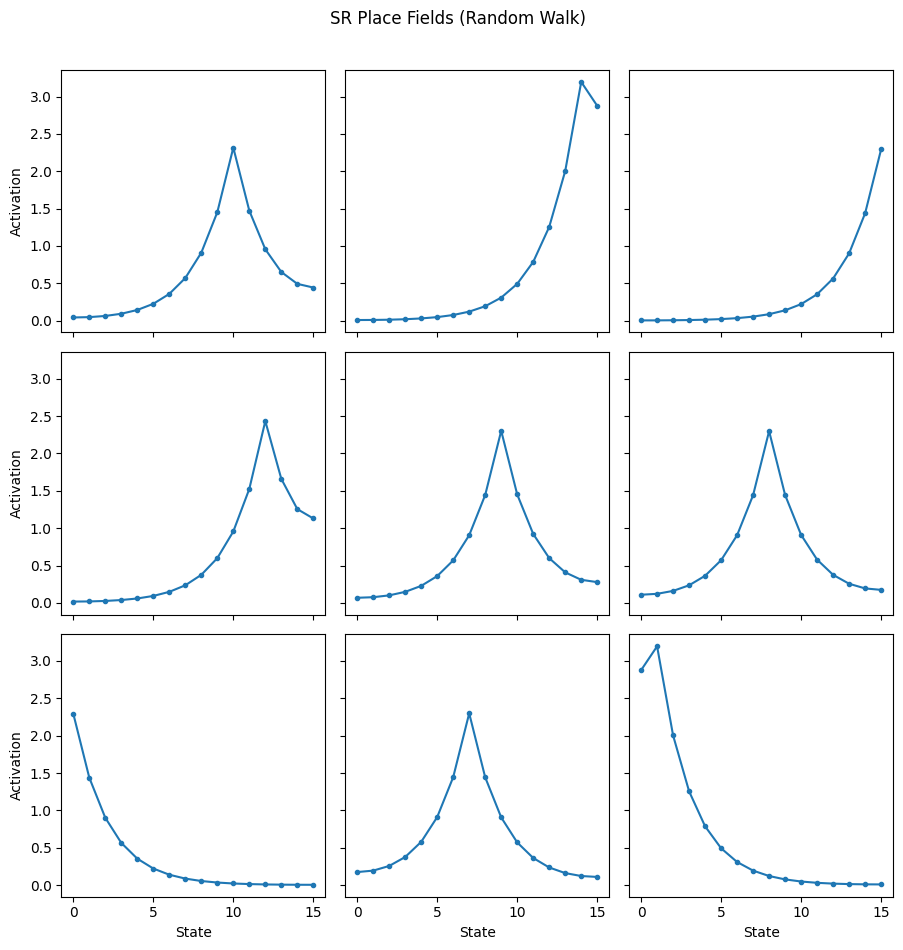

In [196]:
sr = compute_successor_representation(env.trans, discount)
fig, axes = env.plot_fields(np.random.permutation(sr.T).T[:, :9])
fig.suptitle('SR Place Fields (Random Walk)', y=1.05)

Text(0.5, 1.05, 'SR Eigenvectors (Random Walk)')

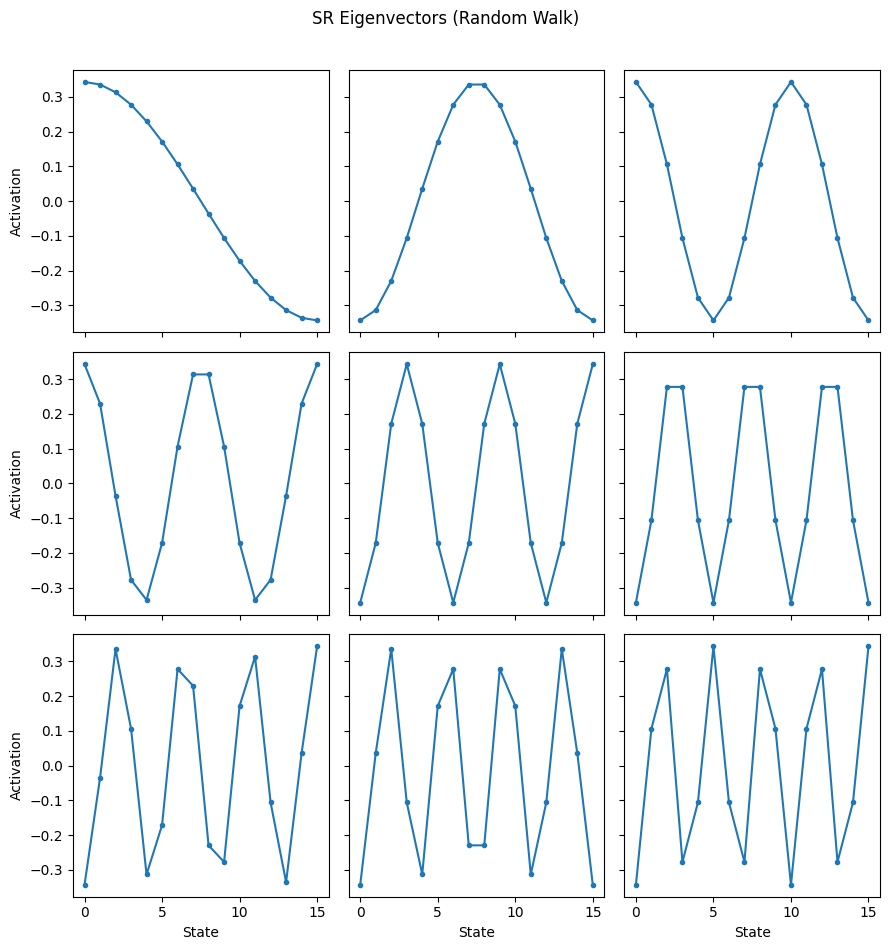

In [197]:
#@title Plot eigenvectors for random walk policy
evals, evecs = compute_eigs(sr)
fig, axes = env.plot_fields(np.real(evecs[:, 1:10]))  # Skip evecs[:, 0] -- near constant for fully connected graph.
fig.suptitle('SR Eigenvectors (Random Walk)', y=1.05)

Text(0.5, 1.0, 'Reward')

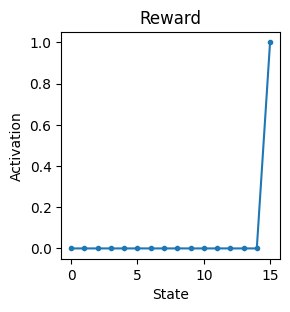

In [198]:
#@title Create random goal location.
goal_node = -1  #@param
reward = np.zeros(env.n)
reward[goal_node] = 1
fig, axes = env.plot_fields(reward)
axes[0, 0].set_title('Reward')

Text(0.5, 1.0, 'Optimal Value')

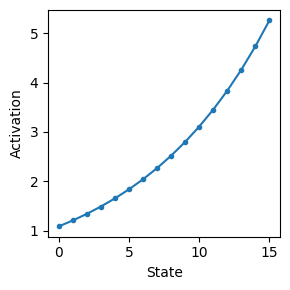

In [199]:
#@title Plot optimal value function
optimal_policy, optimal_value = compute_optimal_policy(env.adj, reward, discount)
env.plot_fields(optimal_value)
axes[0, 0].set_title('Optimal Value')

Text(0.5, 1.05, 'SR Place Fields (Optimal Policy)')

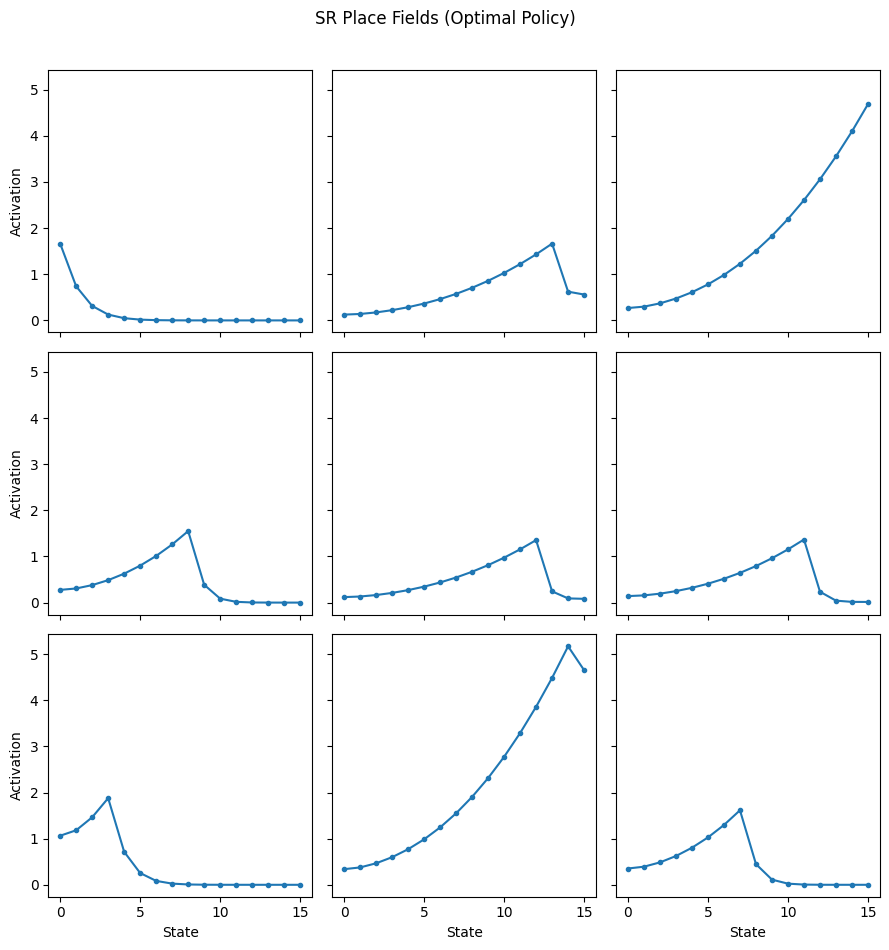

In [200]:
#@title Plot SR place fields for softmax-optimal policy.

beta = 2. #@param
optimal_policy_sftmx = get_softmax_policy(env.adj, optimal_value, beta_sftmx=beta)
optimal_sr = compute_successor_representation(optimal_policy_sftmx, .9)
fig, axes = env.plot_fields(np.random.permutation(optimal_sr.T)[:9, :].T, share_caxis=False)
fig.suptitle('SR Place Fields (Optimal Policy)', y=1.05)

Text(0.5, 1.05, 'SR Eigenvectors (Optimal Policy)')

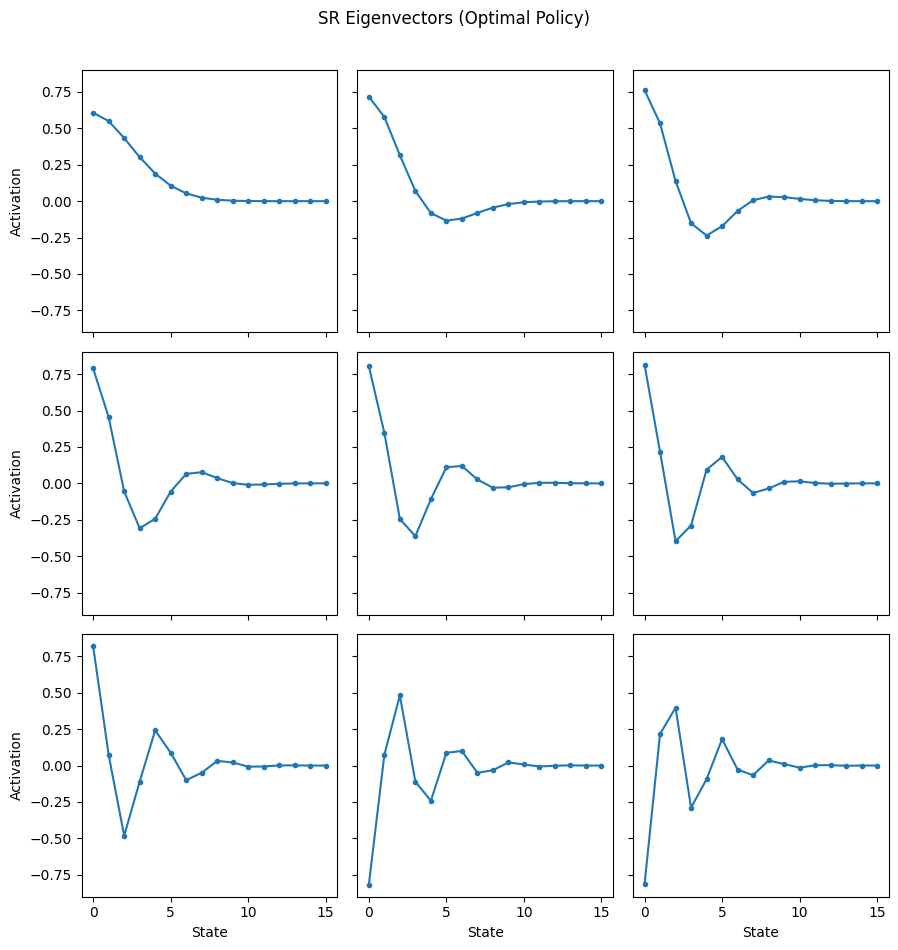

In [201]:
#@title Plot eigenvectors for optimal policy.
evals_opt, evecs_opt = compute_eigs(optimal_sr)
fig, axes = env.plot_fields(np.real(evecs_opt[:, 1:10]))
fig.suptitle('SR Eigenvectors (Optimal Policy)', y=1.05)